In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [23]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

In [24]:
train_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/train'
test_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/val'
batch_size = 16 

In [25]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [26]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 8464 images belonging to 7 classes.

Test Batches: 
Found 1494 images belonging to 7 classes.


In [27]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [28]:
MainInput=Input(shape=(224, 224, 3))

In [29]:
conv=(Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(MainInput))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=64,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [30]:
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

In [31]:
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [32]:
conv=(MaxPooling2D()(conv))

In [33]:
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [34]:
conv=(MaxPooling2D()(conv))

In [35]:
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

Soft Attention Layer

In [36]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv=Activation("relu")(conv)
conv= Dropout(0.5)(conv)

In [37]:
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [38]:
conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

In [39]:
conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(7, activation="softmax")(conv))

model = Model(inputs=MainInput, outputs=conv)

In [40]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                )                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 512)  4719104     ['dropout[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 14, 14, 512)  2048       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 14, 14, 512)  2359808     ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 14, 14, 512)  2048       ['conv2d_11[0][0]']              
 ormalizat

In [41]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [42]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 1.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath ='vgg16+SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [43]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=65, min_delta=0.001)
history = model.fit(train_batches,
#                     steps_per_epoch=(len(train_df)/10),
                    epochs=300,
#                     verbose=2,
                    validation_data=test_batches,
#                     validation_steps=len(test_df)/batch_size,
                    callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/300
529/529 [==============================] - 166s 240ms/step - loss: 2.1366 - accuracy: 0.5304 - val_loss: 1.3391 - val_accuracy: 0.4418
Epoch 2/300
529/529 [==============================] - 130s 245ms/step - loss: 1.4551 - accuracy: 0.5592 - val_loss: 1.2177 - val_accuracy: 0.3440
Epoch 3/300
529/529 [==============================] - 131s 248ms/step - loss: 1.4211 - accuracy: 0.5638 - val_loss: 1.1863 - val_accuracy: 0.5515
Epoch 4/300
529/529 [==============================] - 132s 248ms/step - loss: 1.3972 - accuracy: 0.5839 - val_loss: 1.0534 - val_accuracy: 0.6339
Epoch 5/300
529/529 [==============================] - 130s 245ms/step - loss: 1.3378 - accuracy: 0.6056 - val_loss: 1.1172 - val_accuracy: 0.5154
Epoch 6/300
529/529 [==============================] - 130s 245ms/step - loss: 1.2826 - accuracy: 0.6148 - val_loss: 1.0204 - val_accuracy: 0.6017
Epoch 7/300
529/529 [==============================] - 130s 245ms/step - loss: 1.2344 - accuracy: 0.6400 - val_loss: 1

In [44]:
from tensorflow.keras import models
model.load_weights("vgg16+SA.hdf5")

In [45]:
predictions = model.predict(test_batches, 
#                             steps=len(test_df)/batch_size, 
                            verbose=1)

94/94 [==============================] - 20s 202ms/step


In [46]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.42      0.31      0.35        49
         bcc       0.58      0.66      0.62        77
         bkl       0.48      0.37      0.42       164
          df       0.50      0.24      0.32        17
         mel       0.56      0.40      0.47       167
          nv       0.85      0.94      0.89       999
        vasc       0.83      0.71      0.77        21

    accuracy                           0.77      1494
   macro avg       0.60      0.52      0.55      1494
weighted avg       0.75      0.77      0.75      1494



In [47]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.7473337714550198
Recall: 0.7697456492637216
Accuracy: 0.7697456492637216
weighted Roc score: 0.8945036948666308


In [48]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Precision: 0.6033258343011523
Recall: 0.5184466722129399
Accuracy: 0.7697456492637216
Macro Roc score: 0.8884507763590829


In [49]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.7697456492637216
Recall: 0.7697456492637216
Accuracy: 0.7697456492637216
Micro Roc score: 0.9484504655540202


In [50]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.8816326530612245
The ROC AUC score of bcc is: 0.9140125929116755
The ROC AUC score of bkl is: 0.8251146158078123
The ROC AUC score of df is: 0.8523238679358
The ROC AUC score of mel is: 0.8598612872220895
The ROC AUC score of nv is: 0.9098098098098099
The ROC AUC score of vasc is: 0.9764006077651699


In [51]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

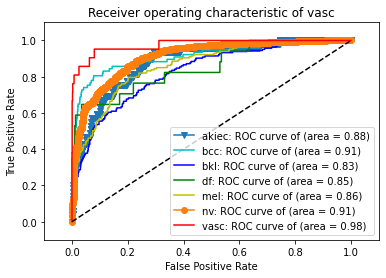

In [52]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()